# Day 08. Exercise 01
# Binary classifier. SVM. Decision tree

## 0. Imports

In [120]:
import pandas as pd
import numpy as np

In [121]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import HoverTool
from bokeh.layouts import gridplot
output_notebook()

Loading BokehJS ...

In [122]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree

## 1. Preprocessing and logreg visualization

Считайте файл `am_pm.csv` в кадр данных из предыдущего упражнения.

1. Постройте график, где ось x - `am`, ось y - `pm`, точки - дни, цвет зависит от цели.
2. Добавьте на график границу принятия решения логистической регрессии.
3. Нарисуйте тот же график (с границей), но цвет на этот раз должен зависеть от прогнозов.

Теперь вам должно быть понятно, как работает логистическая регрессия.

In [123]:
df = pd.read_csv('../data/am_pm.csv', parse_dates=['date'])
df.head()

,date,target,am,pm,predict
0,2020-04-17,working_day,21,2,weekend
1,2020-04-18,weekend,1,68,working_day
2,2020-04-19,weekend,18,15,working_day
3,2020-04-20,working_day,2,23,working_day
4,2020-04-21,working_day,0,25,working_day


In [ ]:
model = LogisticRegression(random_state=21, fit_intercept=False)
model.fit(df[['am', 'pm']], df['target'])

a = -model.coef_[0][0] / model.coef_[0][1]
b = -model.intercept_[0] / model.coef_[0][1]

xx = np.linspace(min(df['am']), max(df['am']))
yy = a * xx + b

In [125]:
def scatter_plot(x1, y1, x2, y2, title):
    fig = figure(title=title,
                    x_axis_label='count_am',
                    y_axis_label='count_pm',
                    width=600, height=400)

    fig.scatter(x1, y1, legend_label='working_day', color='blue', size=10, marker='circle')
    fig.scatter(x2, y2, legend_label='weekend', color='red', size=10, marker='circle')

    fig.legend.location = 'top_right'
    fig.legend.click_policy = 'hide'
    hover = HoverTool()
    hover.tooltips = [
        ("X", "@x"),
        ("Y", "@y"),
    ]
    fig.add_tools(hover)
    return fig

In [126]:
def scatter_line_plot(df, model):
    a = -model.coef_[0][0] / model.coef_[0][1]
    b = -model.intercept_[0] / model.coef_[0][1]

    xx = np.linspace(min(df['am']), max(df['am']))
    yy = a * xx + b

    fig1 = scatter_plot(df[df['target'] == 'working_day']['am'],
                df[df['target'] == 'working_day']['pm'],
                df[df['target'] == 'weekend']['am'],
                df[df['target'] == 'weekend']['pm'], 'target')
    fig1.line(xx, yy, legend_label='decision boundary', line_width=2, line_color='black')

    fig2 = scatter_plot(df[df['predict'] == 'working_day']['am'],
                df[df['predict'] == 'working_day']['pm'],
                df[df['predict'] == 'weekend']['am'],
                df[df['predict'] == 'weekend']['pm'], 'predict')
    fig2.line(xx, yy, legend_label='decision boundary', line_width=2, line_color='black')

    grid = gridplot([[fig1, fig2]])
    show(grid)

In [127]:
scatter_line_plot(df, model)

## 2. Standardizing and logreg

Линейные модели могут быть чувствительны к масштабу переменных. При масштабировании характеристик им легче найти оптимальное решение.

1. Примените `StandardScaler` к `X` и снова обучите логистическую регрессию с теми же параметрами.
2. Рассчитайте `точность` для новой модели. Стала ли она лучше, чем наивный классификатор с наиболее популярным классом?
3. Постройте графики, описанные выше, но для новой модели.

In [128]:
new_df = df.copy()
scaler = StandardScaler()
new_df[['am', 'pm']] = scaler.fit_transform(new_df[['am', 'pm']])

In [129]:
model = LogisticRegression(random_state=21, fit_intercept=False)
model.fit(new_df[['am', 'pm']], new_df['target'])
new_df['predict'] = model.predict(new_df[['am', 'pm']])
print(f'accuracy = {accuracy_score(new_df['target'], new_df['predict'])}')

accuracy = 0.7428571428571429


In [130]:
scatter_line_plot(new_df, model)

## 3. SVM

1. Примените модель `SVC` к масштабированному кадру данных, используя параметры `probability=True`, `random_state=21`.
2. Рассчитайте `точность`.
3. Попробуйте различные ядра, найдите лучшее по точности.
4. Снова нарисуйте оба графика с границами решений, чтобы увидеть, как работает этот алгоритм.

In [131]:
new_df = df.copy()
model = SVC(kernel='poly', probability=True, random_state=21)
new_df[['am', 'pm']] = scaler.fit_transform(new_df[['am', 'pm']])

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(new_df['target'])

model.fit(new_df[['am', 'pm']], y)
new_df['predict'] = model.predict(new_df[['am', 'pm']])
print(f'accuracy = {accuracy_score(y, new_df['predict'])}')
new_df['predict'] = new_df['predict'].apply(lambda x: 'weekend' if x == 0 else 'working_day')

accuracy = 0.7428571428571429


In [132]:
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
param = GridSearchCV(model, param_grid, scoring='accuracy')
param.fit(new_df[['am', 'pm']], new_df['target'])
param.best_params_

{'kernel': 'poly'}

In [133]:
def scatter_area_plot(df, model):
    xx = np.linspace(df['am'].min(), df['am'].max(), 40)
    yy = np.linspace(df['pm'].min(), df['pm'].max(), 40)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model.predict(xy).reshape(XX.shape)


    fig1 = scatter_plot(df[df['target'] == 'working_day']['am'],
                df[df['target'] == 'working_day']['pm'],
                df[df['target'] == 'weekend']['am'],
                df[df['target'] == 'weekend']['pm'], 'target')
    fig1.contour(XX, YY, Z, levels=[0], line_width=2, line_color='black')

    fig2 = scatter_plot(df[df['predict'] == 'working_day']['am'],
                df[df['predict'] == 'working_day']['pm'],
                df[df['predict'] == 'weekend']['am'],
                df[df['predict'] == 'weekend']['pm'], 'predict')
    fig2.contour(XX, YY, Z, levels=[0], line_width=2, line_color='black')

    grid = gridplot([[fig1, fig2]])
    show(grid)

In [134]:
scatter_area_plot(new_df, model)

c:\Users\MMaratR\.conda\envs\data\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


## 4. Decision tree

1. Примените `DecisionTreeClassifier` к масштабированному датафрейму, используя параметры `max_depth=4`, `random_state=42`.
2. Рассчитайте точность.
3. Попробуйте разные значения `max_depth`.
4. Снова нарисуйте оба графика с границами решений, чтобы увидеть, как работает этот алгоритм.
5. С помощью метода `.plot_tree()` визуализируйте само дерево решений. Это еще один способ подумать о том, как работает алгоритм.
6. Сколько листьев в визуализированном дереве обозначают дни как рабочие дни? Запишите свой ответ в ячейку в конце раздела.

In [135]:
new_df = df.copy()
model = DecisionTreeClassifier(max_depth=4, random_state=42)
model.fit(new_df[['am', 'pm']], new_df['target'])
new_df['predict'] = model.predict(new_df[['am', 'pm']])
print(f'accuracy = {accuracy_score(new_df['target'], new_df['predict'])}')

accuracy = 0.9428571428571428


In [136]:
for i in range(1, 7, 1):
    model = DecisionTreeClassifier(max_depth=i, random_state=42)
    model.fit(new_df[['am', 'pm']], new_df['target'])
    print(f'max_depth = {i} accuracy = {accuracy_score(new_df['target'], model.predict(new_df[['am', 'pm']]))}')

max_depth = 1 accuracy = 0.7714285714285715
max_depth = 2 accuracy = 0.8571428571428571
max_depth = 3 accuracy = 0.8857142857142857
max_depth = 4 accuracy = 0.9428571428571428
max_depth = 5 accuracy = 0.9714285714285714
max_depth = 6 accuracy = 1.0


In [137]:
new_df = df.copy()
model = DecisionTreeClassifier(max_depth=6, random_state=42)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(new_df['target'])

model.fit(new_df[['am', 'pm']], y)
new_df['predict'] = model.predict(new_df[['am', 'pm']])
print(f'accuracy = {accuracy_score(y, new_df['predict'])}')
new_df['predict'] = new_df['predict'].apply(lambda x: 'weekend' if x == 0 else 'working_day')

scatter_area_plot(new_df, model)

accuracy = 1.0


c:\Users\MMaratR\.conda\envs\data\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


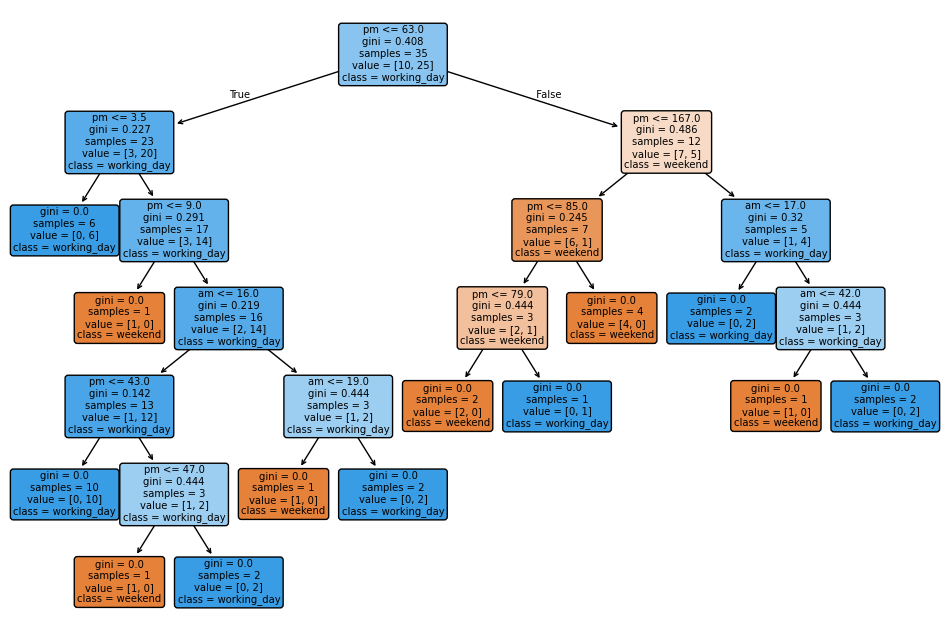

In [138]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))

plot_tree(model,
          feature_names=['am', 'pm'],
          class_names=['weekend', 'working_day'],
          filled=True,
          rounded=True)

plt.show()